# Module 2 - Calculate land and water productivity and perfomance indicators in irrigated system

[![](https://raw.githubusercontent.com//wateraccounting/WaPORMOOC/main/images/colab-badge.png)](https://colab.research.google.com/github/wateraccounting/WaPORIPA/blob/main/Notebooks_beta/Module_2_Calculate_TBP_Yield_WP&IP_indicators.ipynb?target=\"_blank\")


This Notebook calculates from seasonal WaPOR AETI, T and NPP data the following indicators

* Step 0 - Set up: Import modules/libraries, load/import data and define the output folder
* Step 1 - Calculate land and water productivity
      a. Total biomass production
      b. Yield*
      c. Biomass water productivity
      d. Crop water productivity*
* Step 2 - Calculate Irrigation performance indicators:
      a. Uniformity
      b. Beneficial fraction
      c. Adequacy
      d. Relative water deficit

*requires crop type information

####References:
* Chukalla, A. D., Mul, M. L., van der Zaag, P., van Halsema, G., Mubaya, E., Muchanga, E., den Besten, N., and Karimi, P.: [A framework for irrigation performance assessment using WaPOR data: the case of a sugarcane estate in Mozambique](https://doi.org/10.5194/hess-26-2759-2022), Hydrol. Earth Syst. Sci., 26, 2759–2778, 2022.

## Step 0 - Set up

## i) Import packages/libraries

In [1]:
!pip install rasterio --quiet
!pip install rioxarray --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.7/21.7 MB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.5 MB/s eta 0:00:00


In [2]:
import os                                 # Provides functions for interacting with the operating system (e.g., file and directory operations)
import sys                                # Access to system-specific parameters and functions, such as command-line arguments
import glob                               # Used to retrieve files/pathnames matching a specified pattern
import re                                 # Regular expression operations (e.g., re.sub() for substring replacement)
import pandas as pd                       # Data manipulation and analysis, particularly for tabular data in DataFrame format
import numpy as np                        # Provides support for large, multi-dimensional arrays and matrices, along with a collection of mathematical functions
import rasterio as rio                    # Handles raster data input/output and geospatial processing
import rioxarray as riox                  # Extends xarray for geospatial raster data processing and interaction with CRS
import xarray as xr                       # For working with multi-dimensional arrays and datasets, often used with NetCDF and climate data
import calendar                           # Functions related to calendar dates, such as formatting and printing dates
import datetime                           # Supplies classes for manipulating dates and times
from osgeo import gdal                    # Geospatial Data Abstraction Library, used for reading/writing raster and vector geospatial data formats
from matplotlib import pyplot as plt      # Used for creating static, animated, and interactive visualizations (e.g., 2D plots, bar charts)

## ii) Import the input data
Importing required input data for the calculations (seasonal AETI, T and NPP)

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Or, upload .zip file to the temporary repository

In [3]:
# 1) Upload a zip file (pre-module 3 output) containing seasonal data (AETI, T, NPP).
from google.colab import files
uploaded = files.upload()        # Opens a file upload dialog to select a zip file from the local system.

Saving WaPORv3_M1_Seasonal.zip to WaPORv3_M1_Seasonal.zip


In [4]:
# 2) Unzipping the seasonal data into their respective directories (AETI, NPP, T).
!unzip '/content/WaPORv3_M1_Seasonal.zip' -d '/content'

Archive:  /content/WaPORv3_M1_Seasonal.zip
   creating: /content/content/output_M1a/AETI_season/
  inflating: /content/content/output_M1a/AETI_season/AETI_season1_2022-10-01_to_2023-04-30.tif  
   creating: /content/content/output_M1a/NPP_season/
  inflating: /content/content/output_M1a/NPP_season/NPP_season1_2022-10-01_to_2023-04-30.tif  
   creating: /content/content/output_M1a/T_season/
  inflating: /content/content/output_M1a/T_season/T_season1_2022-10-01_to_2023-04-30.tif  


In [5]:
# 3) Set up paths to access the unzipped seasonal AETI, T, and NPP data.
dir_proj = os.path.split(os.getcwd())[0]       # Get the current project directory.
dir_data = r"/content/content/output_M1a/"     # Define the base directory where the data is stored.

# Define paths to the seasonal directories, and retrieve all TIFF files from the respective folders using glob.
input_folderAETI  = os.path.join(dir_proj, dir_data, "AETI_season")
AETI_fhs = glob.glob(os.path.join(input_folderAETI, '*.tif'))

input_folderT  = os.path.join(dir_proj, dir_data, "T_season")
T_fhs = glob.glob(os.path.join(input_folderT, '*.tif'))

input_folderNPP  = os.path.join(dir_proj, dir_data, "NPP_season")
NPP_fhs = glob.glob(os.path.join(input_folderNPP, '*.tif'))

# Output: Lists of file paths for AETI, T, and NPP data.
AETI_fhs, T_fhs, NPP_fhs

(['/content/content/output_M1a/AETI_season/AETI_season1_2022-10-01_to_2023-04-30.tif'],
 ['/content/content/output_M1a/T_season/T_season1_2022-10-01_to_2023-04-30.tif'],
 ['/content/content/output_M1a/NPP_season/NPP_season1_2022-10-01_to_2023-04-30.tif'])

In [6]:
# 4) Upload the second zip file containing additional seasonal data (ETp, GreenBlueET, PCP, RET).
from google.colab import files
uploaded = files.upload()       # Opens a file upload dialog for the second zip file.

Saving WaPORv3_M2_Seasonal.zip to WaPORv3_M2_Seasonal.zip


In [7]:
# 5) Unzipping the second seasonal dataset into their respective directories.
!unzip '/content/WaPORv3_M2_Seasonal.zip' -d '/content'

Archive:  /content/WaPORv3_M2_Seasonal.zip
   creating: /content/content/output_M2/ETp_season/
  inflating: /content/content/output_M2/ETp_season/ETc_season1_2022-10-01_to_2023-04-30.tif  
   creating: /content/content/output_M2/GreenBlueET_season/
  inflating: /content/content/output_M2/GreenBlueET_season/BlueETa_2022-10-01_to_2023-04-30.tif  
  inflating: /content/content/output_M2/GreenBlueET_season/Green&BlueETa.xlsx  
  inflating: /content/content/output_M2/GreenBlueET_season/GreenETa_2022-10-01_to_2023-04-30.tif  
   creating: /content/content/output_M2/PCP_season/
  inflating: /content/content/output_M2/PCP_season/PCP_season1_2022-10-01_to_2023-04-30.tif  
   creating: /content/content/output_M2/RET_season/
  inflating: /content/content/output_M2/RET_season/RET_season1_2022-10-01_to_2023-04-30.tif  


In [12]:
# 6) Set up paths to access the unzipped seasonal ETp data
dir_proj = os.path.split(os.getcwd())[0]  # os.getcwd() is for the current directory
dir_data = r"/content/content/output_M2/"     #update directory

# Define paths to the seasonal directory and retrieve all TIFF files from the respective folder using glob.
input_folderETp  = os.path.join(dir_proj, dir_data, "ETp_season")
ETp_fhs          = glob.glob(os.path.join(input_folderETp, '*.tif'))

# Output: Lists of file paths for ETp
ETp_fhs

['/content/content/output_M2/ETp_season/ETc_season1_2022-10-01_to_2023-04-30.tif']

## ii) Defines (and create) the output folder

In [13]:
# create output_folders

dir_proj = os.path.split(os.getcwd())[0]  # os.getcwd() is for the current directory
dir_data = r"/content/outputM3/"          #update directory

output_folderTBP   = os.path.join(dir_proj, dir_data, "TBP_season")
output_folderyield = os.path.join(dir_proj, dir_data, "yield_season")
output_folderBWP   = os.path.join(dir_proj, dir_data, "BWP_season")
output_foldercWP   = os.path.join(dir_proj, dir_data, "Cwp_season")

# Make one if the folder does not exit
if not os.path.exists(output_folderTBP):
    os.makedirs(output_folderTBP)
if not os.path.exists(output_folderyield):
    os.makedirs(output_folderyield)
if not os.path.exists(output_folderBWP):
    os.makedirs(output_folderBWP)
if not os.path.exists(output_foldercWP):
    os.makedirs(output_foldercWP)

## Step 1: Calculate land and water productivity

Create output folders: Make one or connect to the existing one

### a) Calculate Total Seasonal Biomass Production (Dry Biomass)

Net Primary Production (NPP) can be used to estimate the total dry biomass production using the following formula:

$TBP = (NPP * 22.222) / 1000$

Where:
- NPP is the Net Primary Production in grams of carbon per square meter (gC/m²).
- The constant `22.222` is used to convert NPP from gC/m² to total dry biomass production in kilograms of dry matter per hectare (kgDM/ha).
- Dividing by `1000` converts the result from kilograms per hectare (kg/ha) to tons per hectare (ton/ha).

the mean & SD for  = 3.7 & 2.2


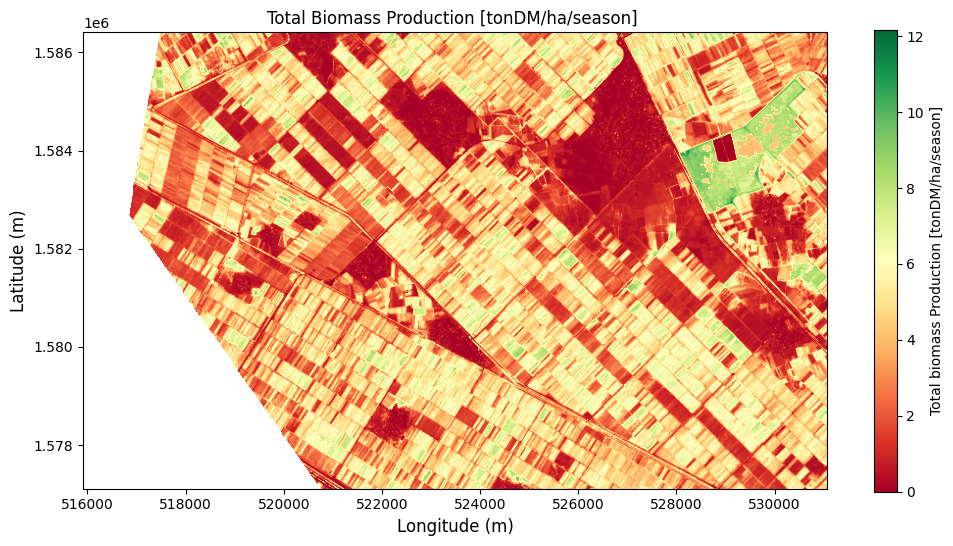

In [14]:
#Total seasonal biomass production
for in_fhsNPP in NPP_fhs:
    NPP  = riox.open_rasterio(in_fhsNPP)
    TBP = (NPP * 22.222) / 1000  # Total biomass production, 1000 is to convert from kg to ton

    # save into output folder
    output_folder = output_folderTBP
    basename = os.path.basename(in_fhsNPP).replace('NPP', 'TBP')
    out_fh = os.path.join(output_folderTBP, basename)

    TBP.rio.to_raster(out_fh)

    # Plot the raster map
    seasonal = TBP
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(1),'&',np.nanstd(seasonal).round(1))


    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='Total biomass Production [tonDM/ha/season]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Total Biomass Production [tonDM/ha/season] ')
    plt.clim()
    plt.show ()

### b) Calculate Yield

Crop parameters

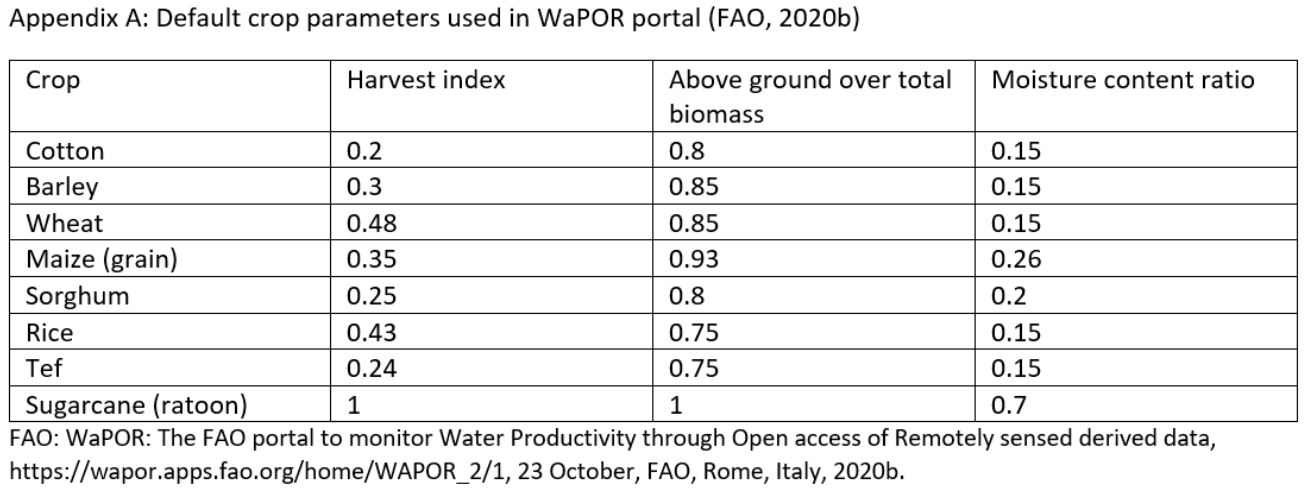

In [15]:
# Update the crop parameters specific to the crop being modeled

MC = 0.15    # Moisture content in the harvested product (fractional). Indicates the amount of water content present in the crop at the time of harvest.
fc = 1       # Light use efficiency correction factor. For C3 plants (like wheat, rice), the value is typically 1, meaning no correction.
AOT = 0.85   # Above (or below) ground over total biomass production ratio (AOT). This ratio indicates that 85% of the total biomass is produced above ground (like stems, leaves, etc.).
HI = 0.48    # Harvest Index (HI), representing the fraction of the above(below) biomass that becomes harvestable yield. A value of 0.48 means 48% of the total biomass contributes to the yield (e.g., grains).


The mean & SD for yield: 1.8 & 1.0


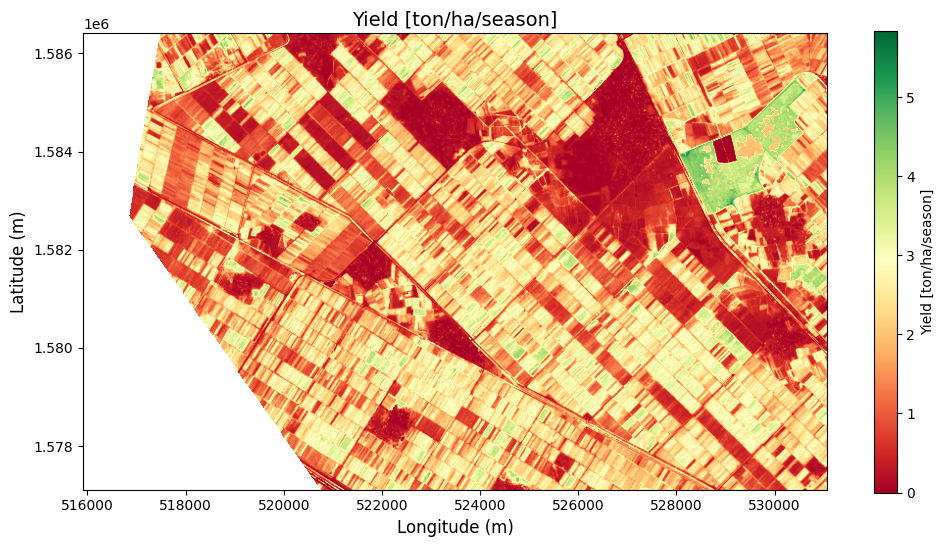

In [16]:
"""
This script computes Harvestable Yield from TBP raster files using crop parameters like HI, AOT, MC, and fc.
The results are saved as raster files, visualized on a color-coded map, and the mean and SD of the yield are calculated and printed.
"""
# Step 1: Load TBP (Total Biomass Production) raster files
TBP_fhs = glob.glob(os.path.join(output_folderTBP, '*.tif'))  # Retrieve all TBP files from the output folder

# Step 2: Loop through each TBP file to compute and save yield
for in_fhsTBP in TBP_fhs:
    TBP = riox.open_rasterio(in_fhsTBP)  # Load the TBP raster file

    # Calculate the Harvestable Yield (Y) using the formula:
    Y = HI * AOT * fc * (TBP / (1 - MC))

    # Step 3: Save the calculated yield (Y) to the output folder
    output_folder = output_folderyield
    basename = os.path.basename(in_fhsTBP).replace('TBP', 'yield')  # Modify the filename for the yield output
    out_fh = os.path.join(output_folderyield, basename)
    Y.rio.to_raster(out_fh)  # Save the yield raster file

    # Step 4: Plot and visualize the Yield data
    seasonal = Y  # Assign the yield data to 'seasonal' for plotting
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())  # Define the spatial extent

    # Step 5: Calculate and print the mean and standard deviation of the yield
    mean_yield = np.nanmean(seasonal).round(1)
    std_yield = np.nanstd(seasonal).round(1)
    print(f'The mean & SD for yield: {mean_yield} & {std_yield}')

    # Step 6: Plot the Yield raster map with a color bar and labels
    plt.figure(figsize=(12, 8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='Yield [ton/ha/season]')
    plt.xlabel('Longitude (m)', fontsize=12)  # Label the x-axis
    plt.ylabel('Latitude (m)', fontsize=12)  # Label the y-axis
    plt.title('Yield [ton/ha/season]', fontsize=14)  # Title for the plot
    plt.clim()
    plt.show()

### c) Calculate Water Productivity

Calculate **biomass water productivity** (WPb), which is defined as the total biomass production divided by the actual evapotranspiration (AETI):

$$ WPb = \frac{TBP}{AETI} \times 100 $$

To adjust the unit, the multiplication by 100 is required for WPb to be expressed in **kgDM/m³**. This adjustment accounts for TBP being in **tonDM/ha** and AETI in **mm/season**.


the mean & SD for  = 0.61 & 0.19


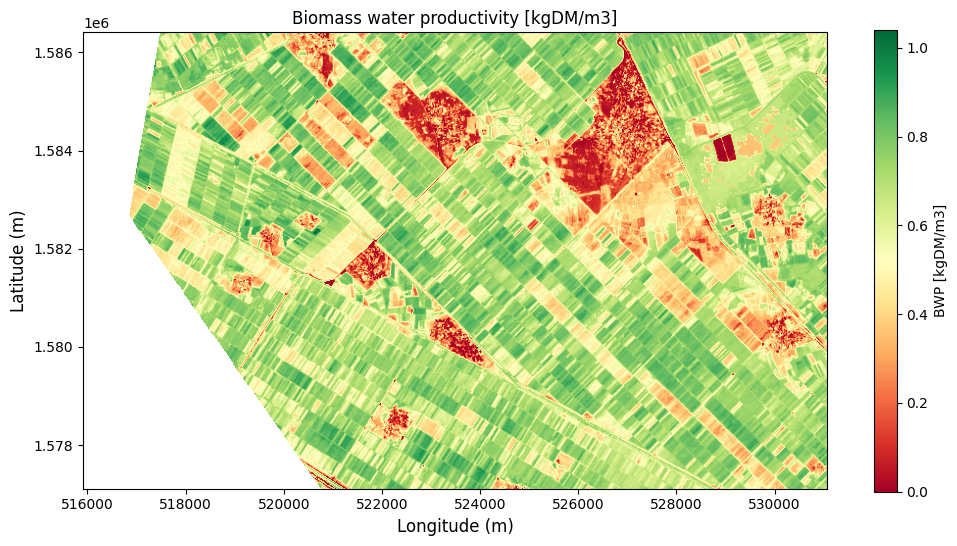

In [17]:
## Calculate biomass WP
for in_fhET, in_fhTBP in zip(AETI_fhs, TBP_fhs):
    AETI = riox.open_rasterio(in_fhET)
    TBP = riox.open_rasterio(in_fhTBP)
    WP  = TBP/AETI*100 # the multiplication with 100 is to correct the units to kg/m3 (from AETI in mm/season and TBP in ton/ha)


    # save into output folder
    output_folder = output_folderBWP
    basename = os.path.basename(in_fhET).replace('AETI', 'BWP')
    out_fh = os.path.join(output_folderBWP, basename)
    WP.rio.to_raster(out_fh)

    # Plot the raster map
    seasonal = WP
    spatial_extent = (seasonal.x.min(), seasonal.x.max(), seasonal.y.min(), seasonal.y.max())

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(2),'&',np.nanstd(seasonal).round(2))

    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='BWP [kgDM/m3]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Biomass water productivity [kgDM/m3]')
    plt.clim()
    plt.show ()

### d) Calculate crop water productivity

**The crop water productivity (cWP)**, defined as the ratio of harvestable yield (Y) to actual evapotranspiration (AETI). The formula used is:

$$ cWP = \frac{Y}{AETI} \times 100 $$

The multiplication by 100 adjusts the units to **kg/m³**, as AETI is in **mm/season** and yield is in **ton/ha**.


the mean & SD for  = 0.61 & 0.19


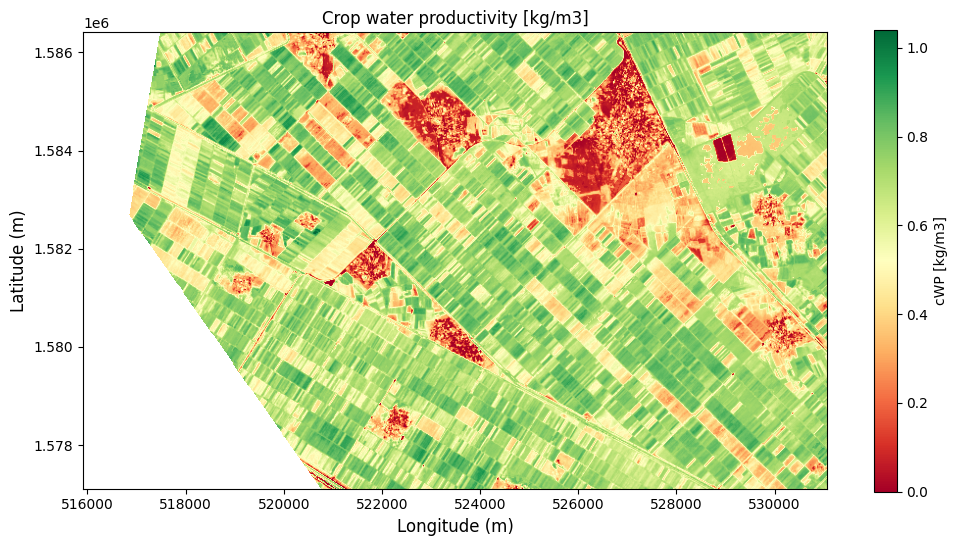

In [18]:
"""
This script calculates crop water productivity (cWP), defined as the ratio of harvestable yield (Y) to actual evapotranspiration (AETI).
The script saves the calculated cWP values as raster files and visualizes them on a map.
Additionally, the mean and standard deviation (SD) of cWP are computed and printed for each raster.
"""

Y_fhs = glob.glob(os.path.join(output_folderyield, '*.tif'))

## Calculate biomass crop WP
for in_fhET, in_fhY in zip(AETI_fhs, Y_fhs):
    AETI = riox.open_rasterio(in_fhET)
    Y = riox.open_rasterio(in_fhY)
    cWP  = Y/AETI*100 # the multiplication with 100 is to correct the units to kg/m3 (from AETI in mm/season and TBP in ton/ha)

    # save into output folder
    output_folder = output_foldercWP
    basename = os.path.basename(in_fhET).replace('AETI', 'cWP')
    out_fh = os.path.join(output_foldercWP, basename)
    cWP.rio.to_raster(out_fh)

    # Plot the raster map

    spatial_extent = (cWP.x.min(), cWP.x.max(), cWP.y.min(), cWP.y.max())

    # calculate the mean, SD
    print ('the mean & SD for ', '=', np.nanmean(seasonal).round(2),'&',np.nanstd(seasonal).round(2))

    plt.figure(figsize = (12,8))
    plt.imshow(seasonal[0], cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
    plt.colorbar(shrink=0.75, label='cWP [kg/m3]')
    plt.xlabel('Longitude (m)', fontsize=12)  # add axes label
    plt.ylabel('Latitude (m)', fontsize=12)
    plt.title('Crop water productivity [kg/m3]')
    plt.clim()
    plt.show ()

## Step 2: Calculate irrigation performance indicators
Create output folders: Make one or connect to the existing one

In [19]:
# Step 1: Create Output Folders for Storing Results

# Set the project directory and specify the output data directory
dir_proj = os.path.split(os.getcwd())[0]  # Get the current project directory
dir_data = r"/content/outputM3/"          # Define the base directory for output data

# Define the paths for the output folders (Beneficial Fraction, Adequacy, and RWD)
output_folderBF = os.path.join(dir_proj, dir_data, "Beneficial_fraction")  # Folder for Beneficial Fraction output
output_folderAd = os.path.join(dir_proj, dir_data, "Adequacy")             # Folder for Adequacy output
output_folderRWD = os.path.join(dir_proj, dir_data, "RWD")                 # Folder for Relative Water Deficit (RWD) output

# Create the folders if they don't already exist
if not os.path.exists(output_folderBF):
    os.makedirs(output_folderBF)  # Create Beneficial Fraction folder if it doesn't exist
if not os.path.exists(output_folderAd):
    os.makedirs(output_folderAd)  # Create Adequacy folder if it doesn't exist
if not os.path.exists(output_folderRWD):
    os.makedirs(output_folderRWD)  # Create RWD folder if it doesn't exist


### a) Calculate Uniformity of Water Consumption (at scheme level)

- The uniformity of water consumption at the scheme level (CV of seasonal average ETa per field inside the scheme) is proxy to measure fairness or **Equity** of seasonal water use within the area of interest.
- It serves as a measure of how evenly water is distributed across an irrigation scheme, reflecting the equitable (uniform) use of water consumption.
  
**Note:**
- A CV between 0% and 10% indicates good uniformity.
- A CV between 10% and 25% indicates fair uniformity.
- A CV greater than 25% indicates poor uniformity.
  (Source: Bastiaanssen et al., 1996)


In [20]:
# Uniformity of water Consumption

for i in range(len(AETI_fhs)):
    with rio.open(AETI_fhs[i]) as dataset:
        AETI = dataset.read(1)  # Read the first band

    AETIm = np.nanmean(AETI)
    AETIsd = np.nanstd(AETI)

    CV_AETI = (AETIsd / AETIm) * 100

    # Identify the date from the file name
    date = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ')

    if CV_AETI < 10:
        U = 'Good Uniformity'
    elif 10 <= CV_AETI < 25:
        U = 'Fair Uniformity'
    else:
        U = 'Poor Uniformity'

    print('CV of AETI in', date, '=', round(CV_AETI, 1), ',', U)


CV of AETI in  season1 2022-10-01 to 2023-04-30 = 46.0 , Poor Uniformity


### b) Calculate Beneficial Fraction

- **Beneficial fraction** is the ratio of the water consumed as transpiration (Ta) compared to the overall field water consumption (ETa).

 <div style="text-indent: 40px;">
$Beneficial fraction = \frac{T_a}{ET_a}$
 </div>

- This fraction is a key measure of the efficiency of on-farm water use and agronomic practices, indicating how effectively water is used for crop growth.


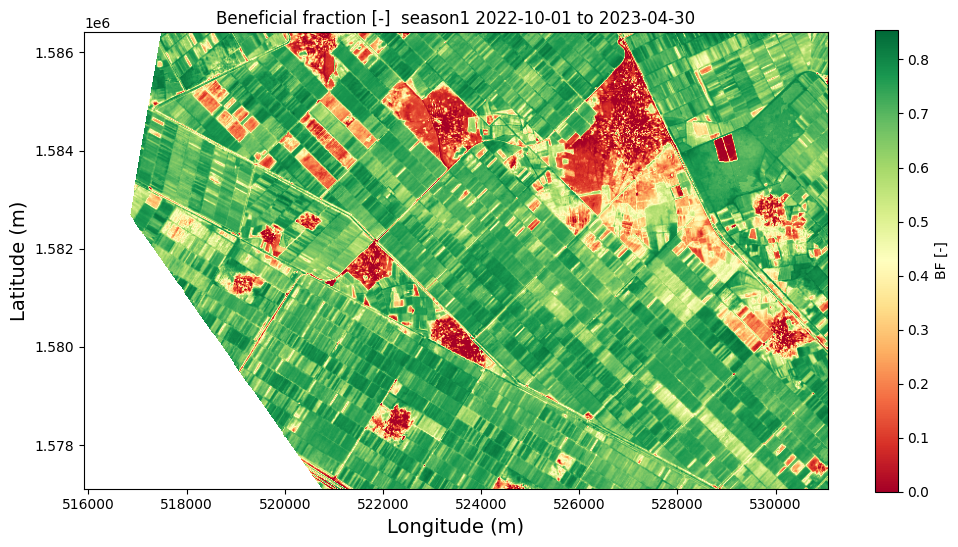

In [21]:
# Beneficial fraction
for Tfh, ETfh in zip(T_fhs, AETI_fhs):
    try:
        T    = riox.open_rasterio(Tfh)
        AETI = riox.open_rasterio(ETfh)

        T_over_AETI = T / AETI

        # Get spatial extent
        spatial_extent = (T_over_AETI.x.min(), T_over_AETI.x.max(), T_over_AETI.y.min(), T_over_AETI.y.max())

        # Identify the date from the file name
        date = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ')

        # Update the file name and save into output folder
        basename = os.path.basename(ETfh).replace('AETI', 'BF')
        output_fn = os.path.join(output_folderBF, basename)
        T_over_AETI.rio.to_raster(output_fn)

        # Plot the raster map
        seasonal = T_over_AETI.squeeze()  # Remove single-dimensional entries from the shape

        plt.figure(figsize=(12, 8))
        plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
        plt.colorbar(shrink=0.75, label='BF [-]')
        plt.xlabel('Longitude (m)', fontsize=14)  # Add axes label
        plt.ylabel('Latitude (m)', fontsize=14)
        plt.title('Beneficial fraction [-] ' + date)
        plt.show()

    except Exception as e:
        print(f"An error occurred with file {ETfh}: {e}")


### c) Calculate adequacy (relative evapotranspiration)
$Adequacy= \frac{ET_a}{ET_p}$

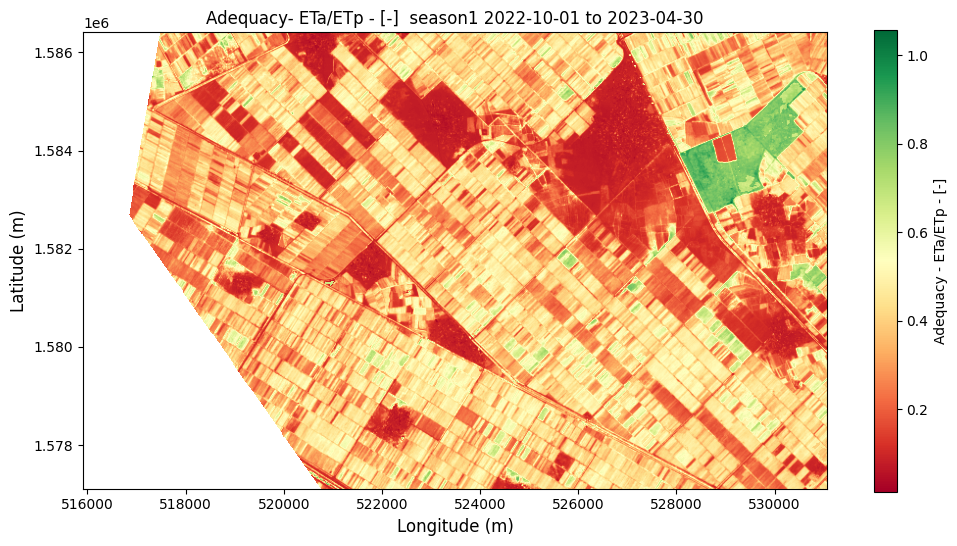

In [23]:
# Adequacy
# Adequacy calculation (ETa/ETp ratio) for each season
# - Reads ETa and ETp raster files
# - Computes ETa/ETp and saves the result
# - Visualizes adequacy with a color-coded map

for Tfh, ETpfh in zip(T_fhs, ETp_fhs):
    try:
        AETI = riox.open_rasterio(ETfh)
        ETp  = riox.open_rasterio(ETpfh)

        ETa_by_ETp = AETI / ETp

        # Get spatial extent
        spatial_extent = (ETa_by_ETp.x.min(), ETa_by_ETp.x.max(), ETa_by_ETp.y.min(), ETa_by_ETp.y.max())

        # Identify the date from the file name
        date = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ')

        # Update the file name and save into output folder
        basename = os.path.basename(ETfh).replace('AETI', 'Adequacy_ETp')
        output_fn = os.path.join(output_folderAd, basename)
        ETa_by_ETp.rio.to_raster(output_fn)

        # Plot the raster map
        seasonal = ETa_by_ETp.squeeze()  # Remove single-dimensional entries from the shape

        plt.figure(figsize=(12, 8))
        plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
        plt.colorbar(shrink=0.75, label='Adequacy - ETa/ETp - [-]')
        plt.xlabel('Longitude (m)', fontsize=12)  # Add axes label
        plt.ylabel('Latitude (m)', fontsize=12)
        plt.title('Adequacy- ETa/ETp - [-] ' + date)
        plt.show()

    except Exception as e:
        print(f"An error occurred with file {ETfh}: {e}")

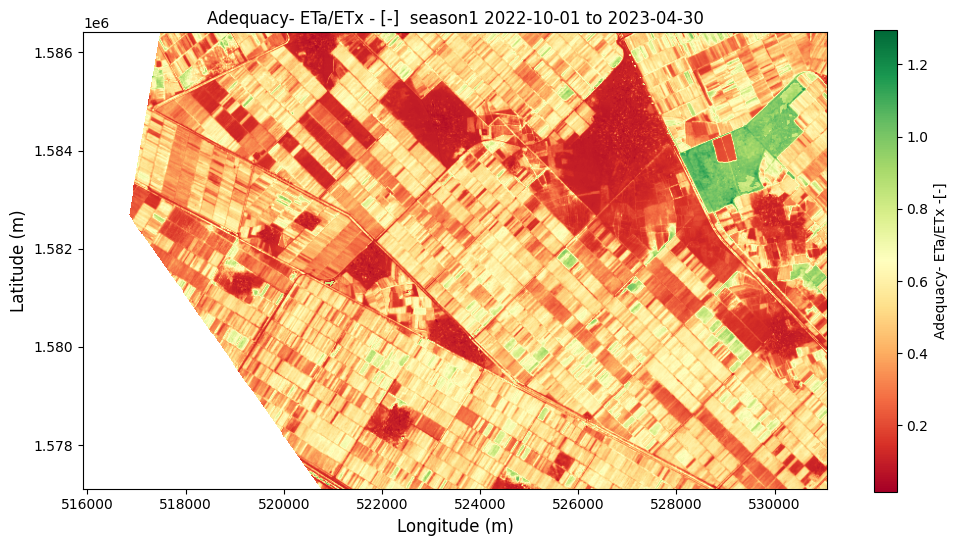

In [24]:
# Adequacy
# Adequacy calculation using the 95th percentile of AETI as ETp (ETx)
# - Computes ETp as the 95th percentile of ETa
# - Calculates ETa/ETx and saves the result
# - Visualizes adequacy with a color-coded map

for ETfh in AETI_fhs:
    try:
        AETI = riox.open_rasterio(ETfh)

        # Compute ETp as the 95th percentile of AETI
        ETp_value = np.nanpercentile(AETI.values, 99)
        ETp = xr.full_like(AETI, ETp_value)

        ETa_by_ETp = AETI / ETp

        # Get spatial extent
        spatial_extent = (ETa_by_ETp.x.min(), ETa_by_ETp.x.max(), ETa_by_ETp.y.min(), ETa_by_ETp.y.max())

        # Identify the date from the file name
        date = os.path.basename(ETfh).split('.')[0].replace('AETI', '').replace('_', ' ')

        # Update the file name and save into output folder
        basename = os.path.basename(ETfh).replace('AETI', 'Adequacy_ETx')
        output_fn = os.path.join(output_folderAd, basename)
        ETa_by_ETp.rio.to_raster(output_fn)

        # Plot the raster map
        seasonal = ETa_by_ETp.squeeze()  # Remove single-dimensional entries from the shape

        plt.figure(figsize=(12, 8))
        plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
        plt.colorbar(shrink=0.75, label='Adequacy- ETa/ETx -[-]')
        plt.xlabel('Longitude (m)', fontsize=12)  # Add axes label
        plt.ylabel('Latitude (m)', fontsize=12)
        plt.title('Adequacy- ETa/ETx - [-] ' + date)
        plt.show()

    except Exception as e:
        print(f"An error occurred with file {ETfh}: {e}")

### d) Calculate Relative Water Deficit (RWD)
$RWD= 1-\frac{ET_a}{ET_x}$

where,
- **ETa**: Actual evapotranspiration.
- **ETx**: Maximum actual evapotranspiration, which can either be the potential evapotranspiration (ETp) or calculated as the highest percentile (e.g., 95th percentile) of the actual evapotranspiration across the area of interest.

The relative water deficit provides insight into the level of water stress experienced by crops due to insufficient water supply.

Relative water deficit [-]  season1 2022-10-01 to 2023-04-30 = 0.41


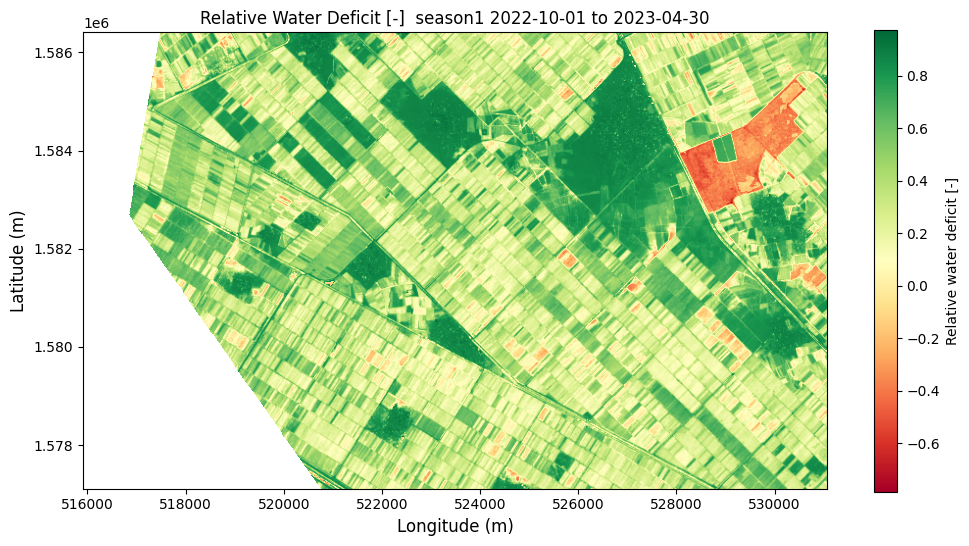

In [25]:
# Relative water deficit (spatial)
# Collecting GeoInfo such as projection, the x and y axis from the first file
in_fh = AETI_fhs[0]
AETI_extend = riox.open_rasterio(in_fh)
spatial_extent = (AETI_extend.x.min(), AETI_extend.x.max(), AETI_extend.y.min(), AETI_extend.y.max())

for i in range(len(AETI_fhs)):
    try:
        # Open the AETI file using rioxarray
        AETI = riox.open_rasterio(AETI_fhs[i])

        # Reshape the array
        AETI1_1D = np.reshape(AETI.values, AETI.shape[1] * AETI.shape[2])
        ETx = np.nanpercentile(AETI1_1D, 95)

        AETI_mean = np.nanmean(AETI.values)

        RWD = 1 - (AETI / ETx)

        # Identify the date from the file name and save the result to the output folder
        date = os.path.basename(AETI_fhs[i]).split('.')[0].replace('AETI', '').replace('_', ' ')

        output_folder = output_folderRWD
        basename = os.path.basename(in_fh).replace('AETI', 'RWD')
        out_fh = os.path.join(output_folderRWD, basename)

        RWD.rio.to_raster(out_fh)

        RWDm = 1 - (AETI_mean/ ETx)

        print('Relative water deficit [-]', date, '=', round(RWDm, 2))

# Plot the raster map
        seasonal = RWD.squeeze()  # Remove single-dimensional entries from the shape

        plt.figure(figsize=(12, 8))
        plt.imshow(seasonal, cmap='RdYlGn', vmin=np.nanmin(seasonal), vmax=np.nanmax(seasonal), extent=spatial_extent)
        plt.colorbar(shrink=0.75, label='Relative water deficit [-]')
        plt.xlabel('Longitude (m)', fontsize=12)  # Add axes label
        plt.ylabel('Latitude (m)', fontsize=12)
        plt.title('Relative Water Deficit [-] ' + date)
        plt.show()

    except Exception as e:
        print(f"An error occurred with file {ETfh}: {e}")


Download files

In [26]:
!zip -r /content/WaPORv3_M3_YWPIPA.zip /content/outputM3
from google.colab import files
files.download(r'/content/WaPORv3_M3_YWPIPA.zip')

  adding: content/outputM3/ (stored 0%)
  adding: content/outputM3/yield_season/ (stored 0%)
  adding: content/outputM3/yield_season/yield_season1_2022-10-01_to_2023-04-30.tif (deflated 20%)
  adding: content/outputM3/Adequacy/ (stored 0%)
  adding: content/outputM3/Adequacy/Adequacy_ETp_season1_2022-10-01_to_2023-04-30.tif (deflated 46%)
  adding: content/outputM3/Adequacy/Adequacy_ETx_season1_2022-10-01_to_2023-04-30.tif (deflated 51%)
  adding: content/outputM3/Beneficial_fraction/ (stored 0%)
  adding: content/outputM3/Beneficial_fraction/BF_season1_2022-10-01_to_2023-04-30.tif (deflated 22%)
  adding: content/outputM3/Cwp_season/ (stored 0%)
  adding: content/outputM3/Cwp_season/cWP_season1_2022-10-01_to_2023-04-30.tif (deflated 20%)
  adding: content/outputM3/TBP_season/ (stored 0%)
  adding: content/outputM3/TBP_season/TBP_season1_2022-10-01_to_2023-04-30.tif (deflated 20%)
  adding: content/outputM3/RWD/ (stored 0%)
  adding: content/outputM3/RWD/RWD_season1_2022-10-01_to_2023-

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>